In [ ]:
pip install pyspark

In [ ]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

+--------------------+--------------------+
|                text|           sentiment|
+--------------------+--------------------+
|RT @NancyLeeGrahn...|             Neutral|
|RT @ScottWalker: ...|            Positive|
|RT @TJMShow: No m...|             Neutral|
|RT @RobGeorge: Th...|            Positive|
|RT @DanScavino: #...|            Positive|
|"RT @GregAbbott_T...|            Positive|
|RT @warriorwoman9...|            Negative|
|Going on #MSNBC L...|             Neutral|
|Deer in the headl...|            Negative|
|RT @NancyOsborne1...|            Negative|
|@JGreenDC @realDo...|            Negative|
|RT @WayneDupreeSh...|            Positive|
|                NULL|Central Time (US ...|
|Me reading my fam...|            Negative|
|"RT @ArcticFox201...|             Neutral|
|RT @pattonoswalt:...|            Positive|
|Hey @ChrisChristi...|            Negative|
|RT @CarolCNN: #Do...|            Negative|
|RT @johncardillo:...|            Negative|
|reason comment is...|          

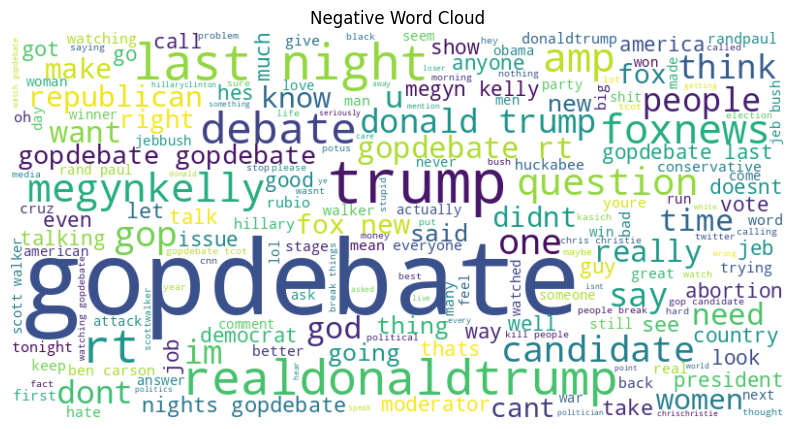

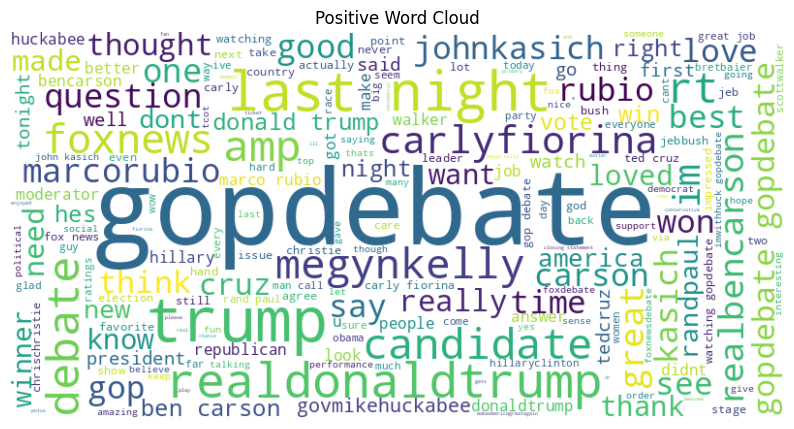

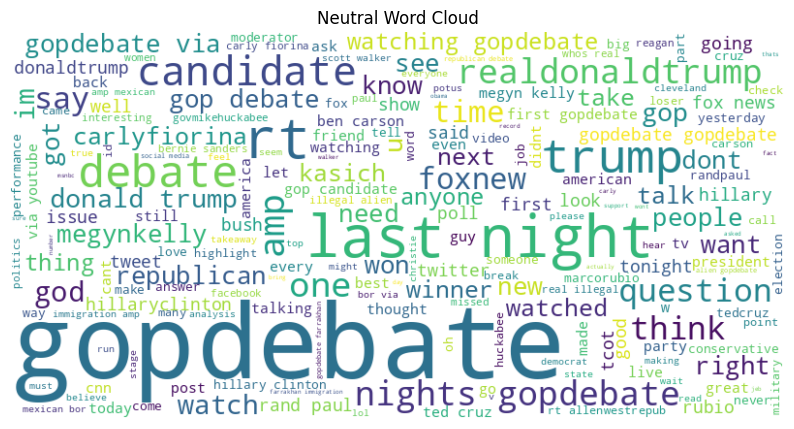


Logistic Regression:

Accuracy: 0.5023328149300156
Precision: 0.5348210858079565
Recall: 0.5023328149300156
F1 Score: 0.5140207452327284



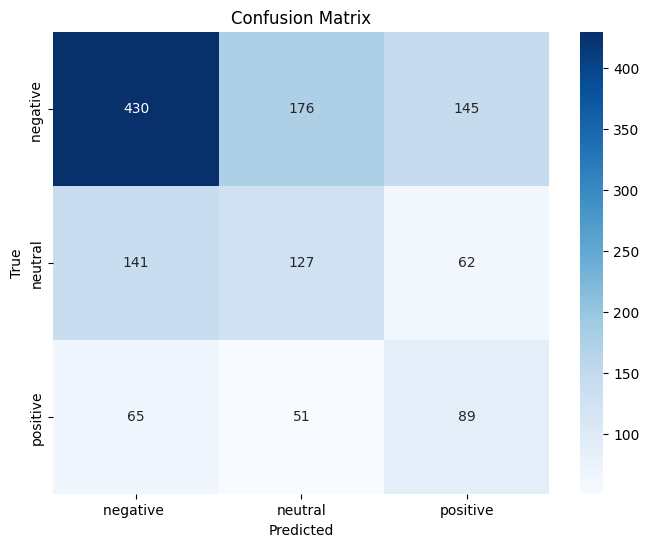


Linear Regression:

Root Mean Squared Error (RMSE): 3.0330106356423268
Accuracy: 0.44245723172628304
Precision: 0.3314814814814815
Recall: 0.5424242424242425
F1-Score: 0.4114942528735632



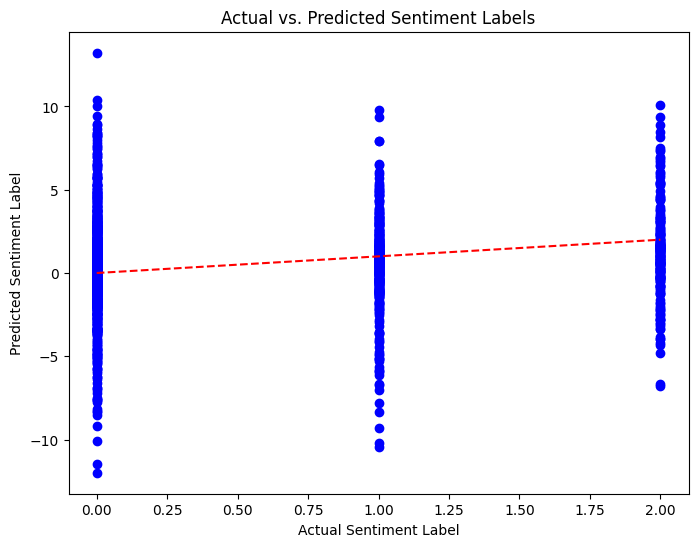


Stochastic Gradient Descent:

Accuracy: 0.6158631415241057
F1-score: 0.5356664435922952
Precision: 0.5925046402930503
Recall: 0.6158631415241058



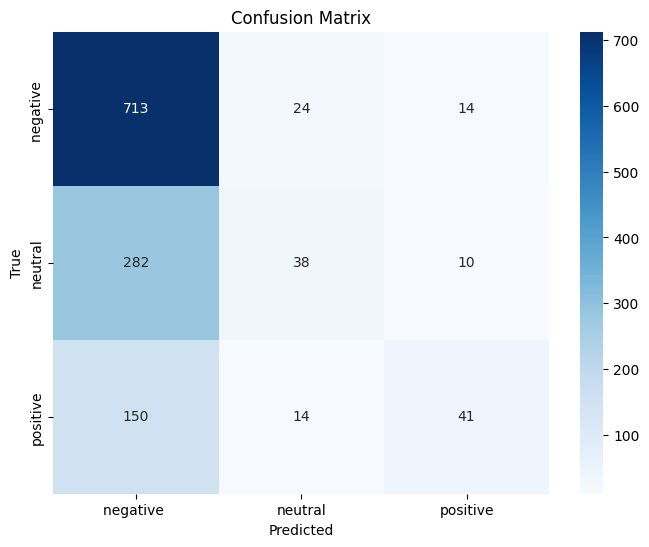


Batch Gradient:

Accuracy: 0.5839813374805599
F1-score: 0.43060381389091845
Precision: 0.3410342025255836
Recall: 0.5839813374805599



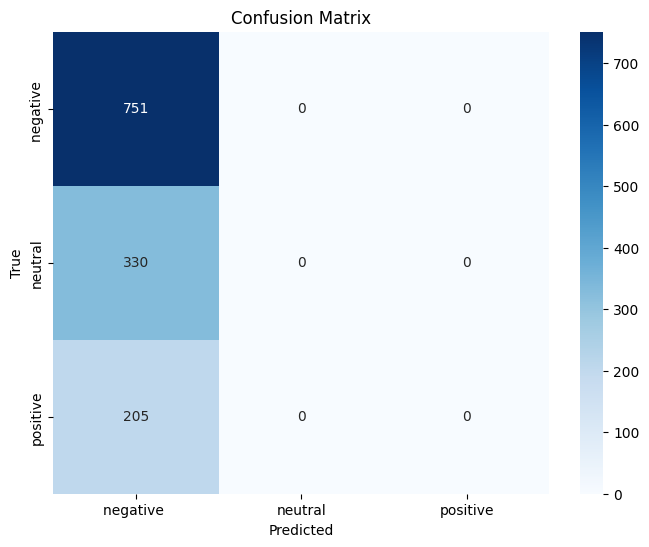

In [31]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("Project").setMaster("local")
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

# Step 1: Data Collection

Data = spark.read.csv("Sentiment.csv", header = True, inferSchema = True)
Data = Data.select(Data.text, Data.sentiment)
Data.show()

# Step 2: Data Cleaning and Preprocessing

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re
from nltk.tokenize import word_tokenize
from pyspark.ml.feature import StopWordsRemover
from nltk.stem import WordNetLemmatizer

# Removing Retweets
Data = Data.filter(~Data.text.startswith("RT"))
# Removing Duplicates
Data = Data.dropDuplicates(["text"])
# To Drop the Null Values ##
Data = Data.na.drop(how = "all")

def Tweet_Preprocessing(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Convert to lowercase
    text = text.lower()

    return text

tweet_preprocessing_udf = udf(Tweet_Preprocessing, StringType())
Data = Data.select(tweet_preprocessing_udf(Data.text).alias("text"), Data.sentiment)

# Tokenization
def Tokenization(text):
  Tokens = word_tokenize(text)

  return Tokens

tokenize_udf = udf(Tokenization, ArrayType(StringType()))
Data = Data.select(tokenize_udf(Data.text).alias("text"), Data.sentiment)

# Removing StopWords
remover = StopWordsRemover(inputCol = "text", outputCol = "filtered_text")
Data = remover.transform(Data)

Data = Data.select(Data.filtered_text.alias("Tweets"), Data.sentiment)
Data.show(truncate = False)

# Step 3: Feature Extraction
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol = "Tweets", outputCol = "rawFeatures", numFeatures = 10000)
Data = hashingTF.transform(Data)

idf = IDF(inputCol = "rawFeatures", outputCol = "Features")
idf_model = idf.fit(Data)
Data = idf_model.transform(Data)

Data = Data.select(Data.Tweets, Data.Features, Data.sentiment)
Data.show(truncate = False)

# Step 4: Generate Word Cloud for Each Sentiment

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

PD_Data = Data.select(Data.Tweets, Data.sentiment).toPandas()

print()
print("Word Cloud:")
print()

for sentiment in PD_Data['sentiment'].unique():
    # Concatenate all tokens for the current sentiment
    tokens = ' '.join(PD_Data[PD_Data['sentiment'] == sentiment]['Tweets'].apply(lambda x: ' '.join(x)))

    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(tokens)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiment + ' Word Cloud')
    plt.axis('off')
    plt.show()

# Step 5: Train-Test Split

train_data, test_data = Data.randomSplit([0.8, 0.2], seed = 42)

# Step 6: Convert Sentiment Labels to Numerical Values

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = "sentiment", outputCol = "label")
train_data = indexer.fit(train_data).transform(train_data)
test_data = indexer.fit(test_data).transform(test_data)

# Step 7: Model Training

# Logistic Regression

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'Features', labelCol = 'label')
lr_model = lr.fit(train_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction', labelCol = 'label', metricName = 'accuracy')

print()
print("Logistic Regression:")
print()

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

precision = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedPrecision")
print("Precision:", precision.evaluate(predictions))

recall = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedRecall")
print("Recall:", recall.evaluate(predictions))

f1 = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "f1")
print("F1 Score:", f1.evaluate(predictions))
print()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels
true_labels = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted_labels = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ['negative ', 'neutral','positive'], yticklabels = ['negative ', 'neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Linear Regression

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol = "Features", labelCol = "label")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

print()
print("Linear Regression:")
print()

evaluator = RegressionEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

from pyspark.sql.functions import when

# Convert predicted values to binary labels based on a threshold (0.5)

threshold = 0.5
predictions_binary = predictions.withColumn("predicted_label", when(predictions["prediction"] >= threshold, 1.0).otherwise(0.0))

accuracy = predictions_binary.filter("label = predicted_label").count() / predictions_binary.count()

tp = predictions_binary.filter("label = 1.0 AND predicted_label = 1.0").count()
tn = predictions_binary.filter("label = 0.0 AND predicted_label = 0.0").count()
fp = predictions_binary.filter("label = 0.0 AND predicted_label = 1.0").count()
fn = predictions_binary.filter("label = 1.0 AND predicted_label = 0.0").count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1_score)
print()

import matplotlib.pyplot as plt

# Extracting actual and predicted values
actual_values = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(8, 6))
plt.scatter(actual_values, predicted_values, color='blue')
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.xlabel("Actual Sentiment Label")
plt.ylabel("Predicted Sentiment Label")
plt.title("Actual vs. Predicted Sentiment Labels")
plt.show()

# Apply Stochastic Gradient Descent (SGD) using Logistic Regression

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sgd = LogisticRegression(featuresCol = "Features", labelCol = "label", maxIter = 100, regParam = 0.01, elasticNetParam = 1.0)
sgd_model = sgd.fit(train_data)

predictions = sgd_model.transform(test_data)

print()
print("Stochastic Gradient Descent:")
print()

evaluator = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "f1")
f1_score = evaluator_f1.evaluate(predictions)
print("F1-score:", f1_score)

evaluator_precision = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print("Precision:", precision)

evaluator_recall = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print("Recall:", recall)
print()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Extracting actual and predicted values
actual_values = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

cm = confusion_matrix(actual_values, predicted_values)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative ', 'neutral','positive'], yticklabels=['negative ', 'neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Batch Gradient
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Apply Logistic Regression
bgd = LogisticRegression(featuresCol="Features", labelCol="label",maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")
bgd_model = bgd.fit(train_data)

# Make predictions on the test data
predictions = bgd_model.transform(test_data)

print()
print("Batch Gradient:")
print()

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print("F1-score:", f1_score)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print("Precision:", precision)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print("Recall:", recall)
print()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Extracting actual and predicted values
actual_values = predictions.select("label").rdd.map(lambda x: x[0]).collect()
predicted_values = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

conmatr = confusion_matrix(actual_values, predicted_values)

plt.figure(figsize=(8, 6))
sns.heatmap(conmatr, annot=True, fmt="d", cmap="Blues", xticklabels=['negative ', 'neutral','positive'], yticklabels=['negative ', 'neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

K-Means:



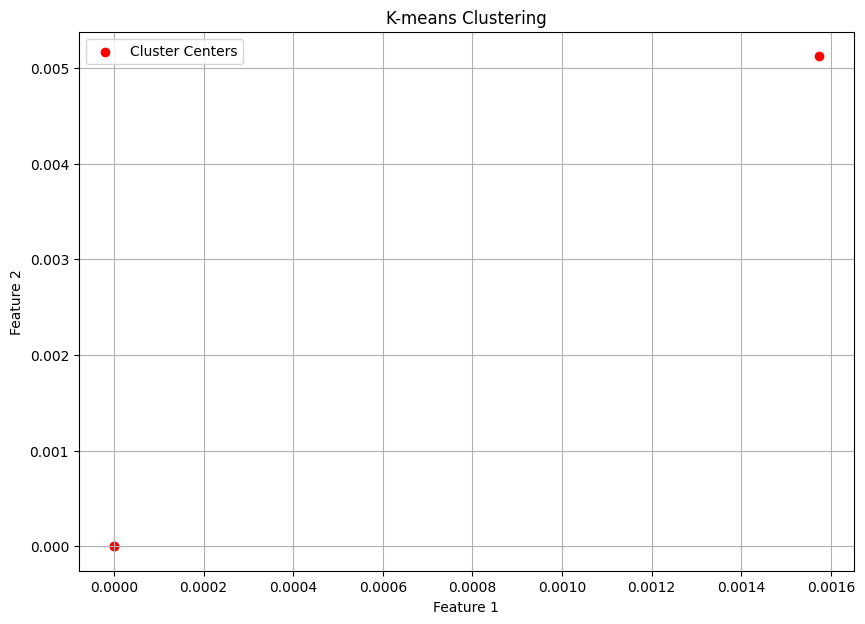


Cluster Centers:
Cluster 1: [0.00157245 0.00512476 0.00679854 ... 0.00157245 0.         0.00157245]
Cluster 2: [0. 0. 0. ... 0. 0. 0.]
Cluster 3: [0. 0. 0. ... 0. 0. 0.]

K-Neighbors:

Accuracy: 0.583701250919794
Precision: 0.6140706542099357
Recall: 0.583701250919794
F1 Score: 0.5612391348526783


<ipython-input-39-0892023a4fe5>:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=PD_Test_Data, palette="coolwarm")


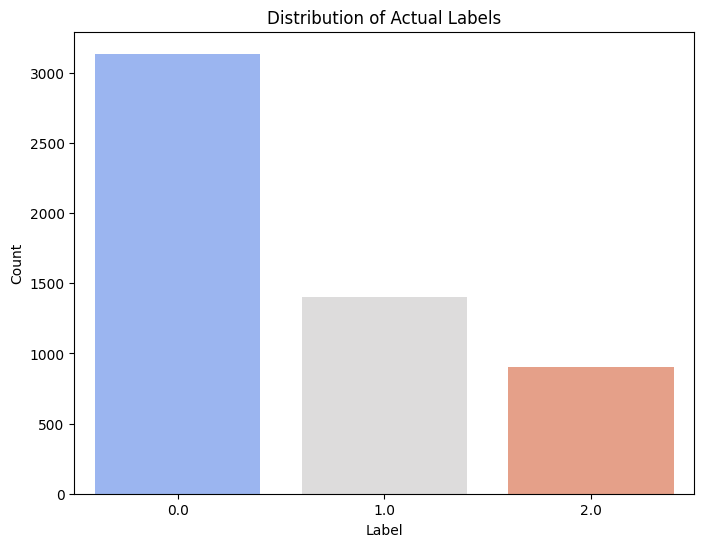

In [39]:
# Bonus Work

# K-Means

Data = spark.read.csv("Sentiment.csv", header = True, inferSchema = True)
Data = Data.select(Data.text, Data.sentiment)

# Step 2: Data Cleaning and Preprocessing

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re
from nltk.tokenize import word_tokenize
from pyspark.ml.feature import StopWordsRemover
from nltk.stem import WordNetLemmatizer

# Removing Retweets
Data = Data.filter(~Data.text.startswith("RT"))
# Removing Duplicates
Data = Data.dropDuplicates(["text"])
# To Drop the Null Values ##
Data = Data.na.drop(how = "all")

def Tweet_Preprocessing(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Convert to lowercase
    text = text.lower()

    return text

tweet_preprocessing_udf = udf(Tweet_Preprocessing, StringType())
Data = Data.select(tweet_preprocessing_udf(Data.text).alias("text"), Data.sentiment)

# Tokenization
def Tokenization(text):
  Tokens = word_tokenize(text)

  return Tokens

tokenize_udf = udf(Tokenization, ArrayType(StringType()))
Data = Data.select(tokenize_udf(Data.text).alias("text"), Data.sentiment)

# Removing StopWords
remover = StopWordsRemover(inputCol = "text", outputCol = "filtered_text")
Data = remover.transform(Data)

Data = Data.select(Data.filtered_text.alias("Tweets"), Data.sentiment)

# Step 3: Feature Extraction
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol = "Tweets", outputCol = "rawFeatures", numFeatures = 10000)
Data = hashingTF.transform(Data)

idf = IDF(inputCol = "rawFeatures", outputCol = "newFeatures")
idf_model = idf.fit(Data)
Data = idf_model.transform(Data)

Data = Data.select(Data.Tweets, Data.newFeatures, Data.sentiment)

# Step 5: Train-Test Split

train_data, test_data = Data.randomSplit([0.8, 0.2], seed = 42)

# Step 6: Convert Sentiment Labels to Numerical Values

from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = "sentiment", outputCol = "label")
train_data = indexer.fit(train_data).transform(train_data)
test_data = indexer.fit(test_data).transform(test_data)

# Step 6: Apply K-means clustering

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Convert features to a single feature vector using VectorAssembler
assembler = VectorAssembler(inputCols=["newFeatures"], outputCol = "features")
train_data = assembler.transform(train_data)

# Assuming you want 3 clusters
kmeans = KMeans(k = 3, seed = 1)
model = kmeans.fit(train_data)

centers = model.clusterCenters()

print("K-Means:")
print()
cluster_centers = np.array(centers)
plt.figure(figsize=(10, 7))
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='o', label='Cluster Centers')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.grid()
plt.show()
print()

# Final clusters
print("Cluster Centers:")
for i, center in enumerate(cluster_centers):
    print("Cluster {}: {}".format(i+1, center))

print()

# K-Neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

PD_Test_Data = train_data.select("features", "label").toPandas()

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(PD_Test_Data["features"].tolist(), PD_Test_Data["label"].tolist())

predictions = knn_model.predict(PD_Test_Data["features"].tolist())

print("K-Neighbors:")
print()

accuracy = (predictions == PD_Test_Data["label"].tolist()).mean()
print("Accuracy:", accuracy)

precision = precision_score(PD_Test_Data["label"].tolist(), predictions, average='weighted')
recall = recall_score(PD_Test_Data["label"].tolist(), predictions, average='weighted')
f1 = f1_score(PD_Test_Data["label"].tolist(), predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=PD_Test_Data, palette="coolwarm")
plt.title("Distribution of Actual Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()